# 毕业项目-驾驶员状态检测

本项目是State Farm公司在Kaggle上发起的一个[竞赛项目](https://www.kaggle.com/c/state-farm-distracted-driver-detection)，目的是得到一个模型，用来检测司机在驾驶过程中是否走神。

该项目要求输入为一张2D彩色图片，输出为10种驾驶状态的概率。10种驾驶状态分别为：
- c0：安全驾驶
- c1：右手打字
- c2：右手打电话
- c3：左手打字
- c4：左手打电话
- c5：调收音机
- c6：喝饮料
- c7：拿后面的东西
- c8：整理头发和化妆
- c9：和其他乘客说话

数据集可以从[Kaggle](https://www.kaggle.com/c/state-farm-distracted-driver-detection/data)上下载。

## 加载和准备数据

先检查本地是否有数据，如果没有则抛出错误提示。如果有，查看数据集的基本信息。

数据名分别为：
- driver_imgs_list.csv.zip
- imgs.zip
- sample_submission.csv.zip

In [1]:
import os
import glob
import cv2
import pickle
import time
from os.path import isfile, isdir

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm, tqdm_notebook
from PIL import Image
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import log_loss
from zipfile import ZipFile

%matplotlib inline

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [2]:
# color_type = 0 - gray
# color_type = 1 - RGB
color_type_global = 1
random_state_global = 2018

# 标签独热编码
encode = LabelBinarizer()
encode.fit(['c0','c1','c2','c3','c4','c5','c6','c7','c8','c9'])

LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False)

In [3]:
# 检查所需文件是否正确下载
assert isfile('imgs.zip'), "No files: imgs.zip"
assert isfile('driver_imgs_list.csv.zip'), "No files: driver_imgs_list.csv.zip" 

# 解压csv数据文件
if not isfile('driver_imgs_list.csv'):
    with ZipFile('driver_imgs_list.csv.zip', 'r') as zipf:
        zipf.extract('driver_imgs_list.csv')
     #   zipf.extractall(path='imgs',members=zipf.namelist()[:10000])
        zipf.close()

# 解压图片集
if not isdir('imgs'):
    with ZipFile('imgs.zip', 'r') as zipf:
        for name in tqdm(zipf.namelist(),desc='Extract files', unit='files'):
            zipf.extract(name,path='imgs')
     #   zipf.extractall(path='imgs',members=zipf.namelist()[:10000])
        zipf.close()

print("All files extracted")

All files extracted


,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg


Training set images numbers: 22424


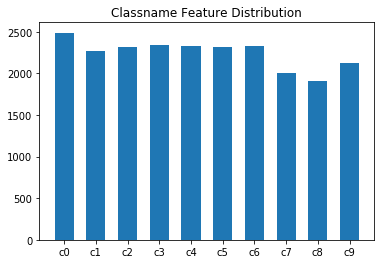

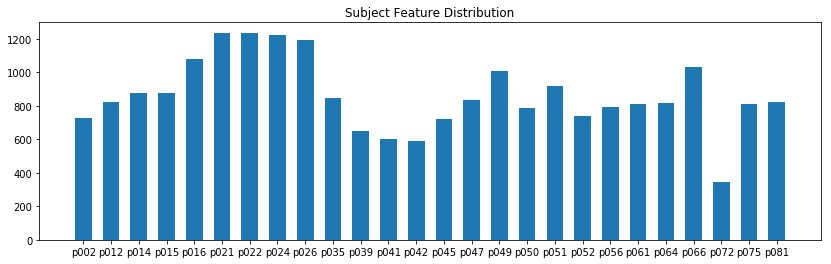

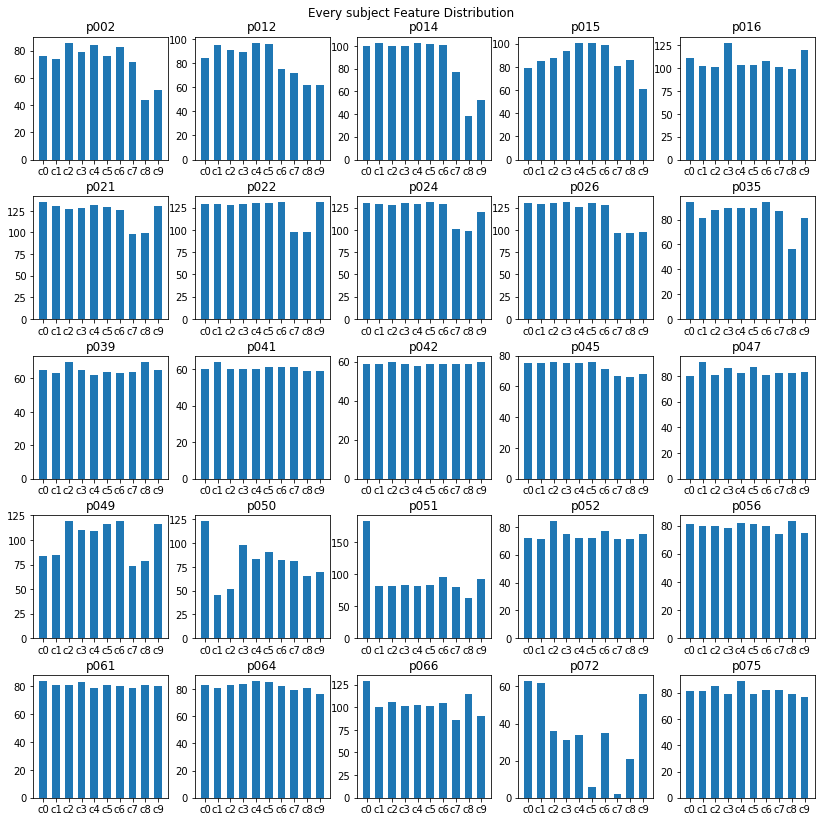

In [4]:
# 导入训练集的数据对应关系列表，显示前三条记录
data = pd.read_csv('driver_imgs_list.csv')
display(data.head(n=3))
print("Training set images numbers: {}".format(data.shape[0]))
    
# 查看训练集中的行为类别分布,classname
# 获得classname对应的数量，按照c0-c9排序（pd.series）
data_class = data['classname'].value_counts().sort_index(axis=0) 
plt.figure(figsize=(6,4))
plt.bar(list(data_class.index), list(data_class), width=0.6)
plt.title("Classname Feature Distribution")

    
# 查看训练集中的驾驶员分布，subject
data_subject = data['subject'].value_counts().sort_index(axis=0)
plt.figure(figsize=(14,4))
plt.bar(list(data_subject.index), data_subject, width=0.6)
plt.title("Subject Feature Distribution")

# 查看每个驾驶员的行为类别分布
list_subject = list(data_subject.index)
fig = plt.figure(figsize=(14,14))
fig.suptitle("Every subject Feature Distribution", y=0.91)
plt.subplots_adjust(hspace=0.3)
for i,subject in enumerate(list_subject[:-1]):
    ax = fig.add_subplot(5, 5, i+1)
    values = data[data.subject==subject]['classname'].value_counts().sort_index(axis=0)
    names = list(values.index)
    ax.bar(names, values, width=0.6)
    ax.set_title("{}".format(subject))

plt.show()

# data：driver_classname_img的对应关系，DataFrame
# data_class：classname为index的序列，Series
# data_subject：driver为index的序列，Series
# list_subject：driver的列表

上面导入了训练集的驾驶员-图片对应关系表，表中分为3列。
- subject：代表驾驶员的代号。
- classname：代表对应的驾驶状态，取值为c0~c9。
- img：代表对应的图片名。

训练集数据共**22424**个，驾驶员共26位，训练集中c0-c9数据量分布比较均衡，多数驾驶员的状态分类也比较均衡。为了能更好的泛化，训练集和验证集可以按照驾驶员ID进行分割。

the image size is: 640 * 480


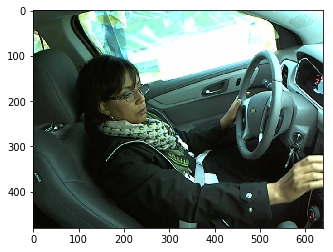

In [5]:
# 导入数据集中的一张图片，显示其尺寸信息
with ZipFile('imgs.zip', 'r') as zipf:
    img_sample = Image.open(zipf.open(zipf.namelist()[1]))
    plt.imshow(np.asarray(img_sample))

    width, height = img_sample.size
    print("the image size is: {} * {}".format(width, height))

### 数据处理
这部分实现数据处理、交叉验证相关的函数。

- `load_train_data_by_drivers(driver_id, img_rows, img_cols, color_type=1)`
    - 根据driver列表提取训练集数据


- `load_test_data(img_rows, img_cols, color_type=1)`
    - 加载测试集数据
   
   
- `merge_folds_mean(data, nfolds)`
    - K折交叉验证得到的预测值取平均
    
    
- `create_submission(predictions, test_id, info)`
    - 创建提交数据，csv文件
    
    
- `run_cross_validation(model, model_str, img_rows, img_cols, driver_id, first_train_num,second_train_num, nfolds=5, batch_size=32, nb_epoch=1,random_state=2018)`
    - 交叉验证


- `test_predict_and_submit(img_rows, img_cols, model_str, nfolds, nb_epoch)`
    - 加载模型测试，生成csv预测结果文件


- `history_plot(history_fit)`
    - 绘制训练过程中的accuracy和loss曲线

In [6]:
# 建立缓存文件夹和提交文件夹
if not os.path.isdir('cache'):
    os.mkdir('cache')
if not os.path.isdir('submission'):
    os.mkdir('submission')

In [7]:
## 根据传入的drivers列表提取训练集数据，resize至需要的尺寸，保存为 np.uint8 格式
def load_train_data_by_drivers(driver_id, img_rows, img_cols, color_type=1):
    '''
    discription：根据driver列表提取训练集数据，图像不进行归一化处理。
    return：x_train，y_train（np.uint8）
    
    driver_id：list，需要提取数据的driver的列表
    img_rows：int，图片的行像素
    img_col：int，图片的列像素
    '''
    x_train = []
    y_train = []
    
    for driver in tqdm(driver_id, desc='load drivers'):
        driver_data = data[data.subject==driver]
        for _,_data in driver_data.iterrows():
            data_path = "imgs/train/{}/{}".format(_data['classname'], _data['img'])
            image = cv2.imread(data_path, color_type)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)      # BGR --> RGB
            image = cv2.resize(image, (img_rows, img_cols))
            feature = np.array(image, dtype=np.uint8) 
            label = _data['classname']
            
            x_train.append(feature)
            y_train.append(label)
            
    
    # 对标签进行独热编码，LabelBinarizer()
    y_train = np.array(encode.transform(y_train), dtype=np.uint8)
    
    # 将数据随机打乱,test_size=0
    x_train, x_test, y_train, y_test = train_test_split(x_train, y_train,
                                                        test_size=0,
                                                        random_state=random_state_global)
    
    x_train = np.array(x_train, dtype=np.uint8)
    
    
    return x_train, y_train

In [9]:
# 加载测试集数据，resize至需要的尺寸，保存为 np.uint8 格式
def load_test_data(img_rows, img_cols, color_type=1):
    '''
    description：加载测试集数据，resize至需要的尺寸。
    return：x_test, x_test_id
    
    img_rows：int，图片的行像素
    img_col：int，图片的列像素
    '''
    print('read test images...')
    data_path = os.path.join('.', 'imgs', 'test', '*.jpg')
    files = glob.glob(data_path)    # 抓取所有的图片路径，保存为列表
    files_pbar = tqdm(files, desc='load test images', total=len(files)) 
    
    x_test = np.zeros((len(files), img_rows, img_cols, 3), dtype=np.uint8) 
    x_test_id = []
    for i,file in enumerate(files_pbar):
        file_name = os.path.basename(file)
        image = cv2.imread(file, color_type)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)      # BGR --> RGB
        image = cv2.resize(image, (img_rows, img_cols))
        image = np.array(image, dtype=np.uint8)
        x_test[i] = image
        x_test_id.append(file_name)
    
    return x_test, x_test_id
    

In [11]:
# K折交叉验证得到的预测值取平均
def merge_folds_mean(data, nfolds):
    a = np.array(data[0])
    for i in range(1, nfolds):
        a += np.array(data[i])
    a /= nfolds
    return a.tolist()

In [12]:
# 创建提交数据，csv文件
def create_submission(predictions, test_id, info):
    result = pd.DataFrame(predictions,
                           columns=['c0','c1','c2','c3','c4','c5','c6','c7','c8','c9'])
    result.insert(0, 'img', test_id)
    result = result.sort_values(by=['img'])
    now = time.localtime()
    if not os.path.isdir('submission'):
        os.mkdir('submission')
    suffix = info + '_' + time.strftime("%Y%m%d_%H%M", now)
    sub_file = os.path.join('submission', 'subm_' + suffix + '.csv')
    result.to_csv(sub_file, index=False)

In [14]:
# 交叉验证
def run_cross_validation(MODEL, img_rows, img_cols, driver_id, first_train_num, optimizer2,
                         nfolds=5, batch_size=32, nb_epoch1=1, nb_epoch2=10, random_state=2018):
    '''
    discription: 根据指定的模型进行 K 折交叉验证，训练 K 个模型，并保存为 .h5 格式。
    
    model: 传入的模型，VGG16，ResNet50，InceptionResNetV2 
    img_rows, img_cols：图片缩放后大小
    driver_id: 所有司机的列表
    first_train_num, second_train_num: 粗调和精调锁定的层数
    nfolds：交叉验证的折数
    batch_size: mini-batch梯度下降的批尺寸
    nb_epoch1, nb_epoch2: 粗调和精调重复的“轮数”
    random_state: 随机数
    
    '''
    kf = KFold(n_splits=nfolds, shuffle=True, random_state=random_state_global)
    
    num_fold = 0
    num_train = 0
    sum_score = 0
    history1_fit = []
    for train_index, test_index in kf.split(driver_id):
        num_fold += 1
        print('Start KFold number {} from {}'.format(num_fold, nfolds))
        
        # 导入模型，每折重新赋值
        model = MODEL(img_rows, img_cols, color_type_global)
        
        train_driver_id = [driver_id[i] for i in train_index]
        test_driver_id = [driver_id[i] for i in test_index]
        x_train, y_train = load_train_data_by_drivers(train_driver_id, img_rows,
                                                      img_cols, color_type_global)
        x_valid, y_valid = load_train_data_by_drivers(test_driver_id, img_rows,
                                                      img_cols, color_type_global)
            
        print('Split train: ', len(x_train), len(y_train))
        print('Split valid: ', len(x_valid), len(y_valid))
        print('Train drivers: ', train_driver_id)
        print('Test drivers: ', test_driver_id)
        
        # first: 仅训练全连接层（权重随机初始化的）
        # 冻结所有卷积层
        for layer in model.layers[:first_train_num]:
            layer.trainable = False
        model.compile(optimizer='adadelta', loss='categorical_crossentropy',
                      metrics=['accuracy'])
        history1_fit = model.fit(x=x_train, y=y_train, batch_size=batch_size, epochs=nb_epoch1, 
                                 shuffle=True, verbose=1, validation_data=(x_valid, y_valid))
        print('Finish step_1')
        
        # second: 所有层进行fine tune
        for layer in model.layers[:]:
            layer.trainable = True
            
        es = EarlyStopping(monitor='val_loss', patience=4)
        model_name = model.name + '_' + str(num_fold) + '.hdf5'
        mc = ModelCheckpoint(os.path.join('cache', model_name), monitor='val_loss',
                             save_best_only=True, mode='min')
        #model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), 
        #              loss='categorical_crossentropy', metrics=['accuracy'])
        model.compile(optimizer=optimizer2, loss='categorical_crossentropy',
                      metrics=['accuracy'])
        history2_fit = model.fit(x=x_train, y=y_train, batch_size=batch_size, epochs=nb_epoch2, 
                                 shuffle=True, verbose=1, validation_data=(x_valid, y_valid),
                                 callbacks=[es, mc])
        print('Finish step_2')
        
        # 展示finetune的loss和accuracy曲线
        history_plot(history2_fit)
        
        predictions_valid = model.predict(x_valid, batch_size=batch_size, verbose=1)
        score_valid = log_loss(y_valid, predictions_valid)
        print('Score log_loss: ', score_valid)
        print()
        
        # 计算总的log_loss
        sum_score += score_valid * len(y_valid)
        num_train += len(y_valid)
        
    score = sum_score / num_train
    print('Final log_loss: {}, nfolds: {}, epoch: {} '.format(score, nfolds, nb_epoch2))
    

优化：
1. 先训练全连接层，再finetune所有层(SGD学习率0.0001)
2. epoch1 = 1, epoch2 = 10
3. 加入early-stopping，防过拟合

In [15]:
# predict test
def test_predict_and_submit(img_rows, img_cols, model_str, nfolds, nb_epoch):
    # 加载测试集
    test_data, test_id = load_test_data(img_rows, img_cols, color_type_global)
    
    yfull_test = []
    
    for index in range(1, nfolds + 1):
        # 加载模型
        
        if(model_str=='inception_resnet_v2'):
            custom_objects = {'preprocess_input': inception_resnet_v2.preprocess_input, 
                              '_preprocess_symbolic_input': imagenet_utils._preprocess_symbolic_input,
                              'imagenet_utils':imagenet_utils}
            model_name = model_str + '_' + str(index) + '.hdf5'
        else:
            custom_objects = {'preprocess_input': imagenet_utils.preprocess_input, 
                              '_preprocess_symbolic_input': imagenet_utils._preprocess_symbolic_input}
            model_name = model_str + '_' + str(index) + '.hdf5'
        
        model = load_model(os.path.join('cache', model_name), custom_objects=custom_objects)
        test_prediction = model.predict(test_data, batch_size=32, verbose=1)
        yfull_test.append(test_prediction)
    
    info_string = 'loss_' + model_str + '_r_' + str(img_rows) + '_c_' + str(img_cols)\
                  + '_folds_' + str(nfolds) + '_ep_' + str(nb_epoch)
    test_result = merge_folds_mean(yfull_test, nfolds)
    create_submission(test_result, test_id, info_string)
    
    print('test finished')

In [16]:
# 将训练过程中的loss绘出，1行2列
def history_plot(history_fit):
    plt.figure(figsize=(12,6))
    # summarize history for accuracy
    plt.subplot(121)
    plt.plot(history_fit.history['acc'])
    plt.plot(history_fit.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    # summarize history for loss
    plt.subplot(122)
    plt.plot(history_fit.history['loss'])
    plt.plot(history_fit.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

## fine-tune模型
分别对VGG16、ResNet50和InceptionResNetV2的预训练模型进行fine-tune.

In [17]:
# 加载需要的keras模块
from keras.models import Model, load_model, save_model
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Lambda
from keras.applications import VGG16, ResNet50, InceptionResNetV2, inception_resnet_v2
from keras.applications import imagenet_utils
from keras import optimizers, Input
from keras import backend as K
from keras.optimizers import SGD
from keras.utils.vis_utils import plot_model, model_to_dot
from keras.callbacks import EarlyStopping, ModelCheckpoint


from IPython.display import SVG

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### VGG16
输入为(224,224,3)，加载`VGG16-no_top`模型及预训练权重，`pooling`选择`avg`(GlobalAveragePooling2D)；

手动添加`dense`、`dropout`层，输出为10类，激活函数为`softmax`。

In [19]:
# VGG16
def vgg16_model(img_rows, img_cols, color_type=1):
    x = Input(shape=(img_rows, img_cols, 3))
    x = Lambda(imagenet_utils.preprocess_input)(x)   # 对每一个传入的tensor进行预处理
    base_model = VGG16(input_tensor=x, weights='imagenet',
                       include_top=False, pooling='avg')
    x = base_model.output
    x = Dense(512, activation='relu', name='fc1')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(10, activation='softmax', name='predictions')(x)

    vgg_model = Model(inputs=base_model.input, outputs=predictions, name='vgg16')
    #vgg_model.compile(optimizer='adadelta', loss='categorical_crossentropy',
    #                  metrics=['accuracy'])
    return vgg_model

In [24]:
plot_model(vgg_model, show_shapes=True, to_file='vgg_model_simple.png')
SVG(model_to_dot(vgg_model, show_shapes=True).create(prog='dot', format='svg'))

Start KFold number 1 from 5


load drivers: 100%|██████████| 6/6 [00:31<00:00,  5.19s/it]


Split train:  17885 17885
Split valid:  4539 4539
Train drivers:  ['p002', 'p012', 'p014', 'p021', 'p022', 'p024', 'p026', 'p035', 'p039', 'p041', 'p045', 'p049', 'p050', 'p051', 'p052', 'p056', 'p061', 'p064', 'p066', 'p081']
Test drivers:  ['p015', 'p016', 'p042', 'p047', 'p072', 'p075']
Train on 17885 samples, validate on 4539 samples
Epoch 1/1
17885/17885 [==============================] - 110s 6ms/step - loss: 1.4664 - acc: 0.6420 - val_loss: 1.8169 - val_acc: 0.4836
Finish step_1
Train on 17885 samples, validate on 4539 samples
Epoch 1/10
17885/17885 [==============================] - 108s 6ms/step - loss: 0.1620 - acc: 0.9507 - val_loss: 1.2015 - val_acc: 0.6270
Epoch 2/10
17885/17885 [==============================] - 105s 6ms/step - loss: 0.0477 - acc: 0.9858 - val_loss: 0.9384 - val_acc: 0.7162
Epoch 3/10
17885/17885 [==============================] - 105s 6ms/step - loss: 0.0296 - acc: 0.9903 - val_loss: 0.7596 - val_acc: 0.7696
Epoch 4/10
17885/17885 [======================

load drivers: 100%|██████████| 5/5 [00:33<00:00,  6.79s/it]


Split train:  17121 17121
Split valid:  5303 5303
Train drivers:  ['p002', 'p012', 'p014', 'p015', 'p016', 'p022', 'p035', 'p039', 'p041', 'p042', 'p047', 'p049', 'p050', 'p052', 'p056', 'p061', 'p064', 'p066', 'p072', 'p075', 'p081']
Test drivers:  ['p021', 'p024', 'p026', 'p045', 'p051']
Train on 17121 samples, validate on 5303 samples
Epoch 1/1
17121/17121 [==============================] - 47s 3ms/step - loss: 1.3984 - acc: 0.6399 - val_loss: 1.3179 - val_acc: 0.5829
Finish step_1
Train on 17121 samples, validate on 5303 samples
Epoch 1/10
17121/17121 [==============================] - 102s 6ms/step - loss: 0.1681 - acc: 0.9484 - val_loss: 0.8442 - val_acc: 0.7392
Epoch 2/10
17121/17121 [==============================] - 102s 6ms/step - loss: 0.0508 - acc: 0.9849 - val_loss: 0.8686 - val_acc: 0.7434
Epoch 3/10
17121/17121 [==============================] - 102s 6ms/step - loss: 0.0304 - acc: 0.9905 - val_loss: 0.7021 - val_acc: 0.8026
Epoch 4/10
17121/17121 [=======================

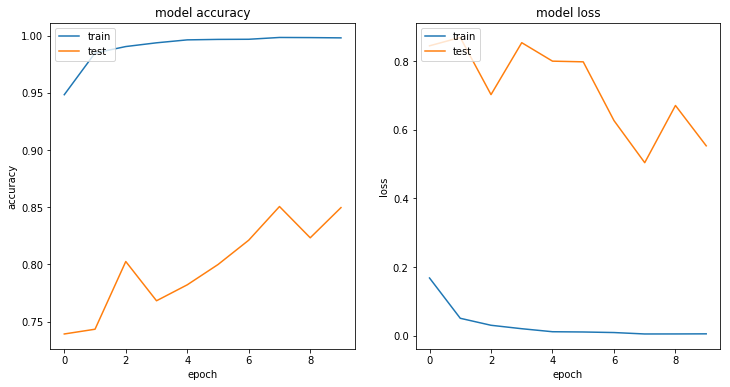

5303/5303 [==============================] - 10s 2ms/step
Score log_loss:  0.5539446971131954

Start KFold number 3 from 5


load drivers: 100%|██████████| 5/5 [00:24<00:00,  4.91s/it]


Split train:  18695 18695
Split valid:  3729 3729
Train drivers:  ['p014', 'p015', 'p016', 'p021', 'p022', 'p024', 'p026', 'p035', 'p041', 'p042', 'p045', 'p047', 'p049', 'p051', 'p056', 'p061', 'p064', 'p066', 'p072', 'p075', 'p081']
Test drivers:  ['p002', 'p012', 'p039', 'p050', 'p052']
Train on 18695 samples, validate on 3729 samples
Epoch 1/1
18695/18695 [==============================] - 45s 2ms/step - loss: 1.3295 - acc: 0.6461 - val_loss: 1.2170 - val_acc: 0.6095
Finish step_1
Train on 18695 samples, validate on 3729 samples
Epoch 1/10
18695/18695 [==============================] - 108s 6ms/step - loss: 0.1581 - acc: 0.9497 - val_loss: 0.8460 - val_acc: 0.7536
Epoch 2/10
18695/18695 [==============================] - 107s 6ms/step - loss: 0.0487 - acc: 0.9858 - val_loss: 0.7315 - val_acc: 0.8109
Epoch 3/10
18695/18695 [==============================] - 107s 6ms/step - loss: 0.0268 - acc: 0.9919 - val_loss: 0.7749 - val_acc: 0.8010
Epoch 4/10
18695/18695 [=======================

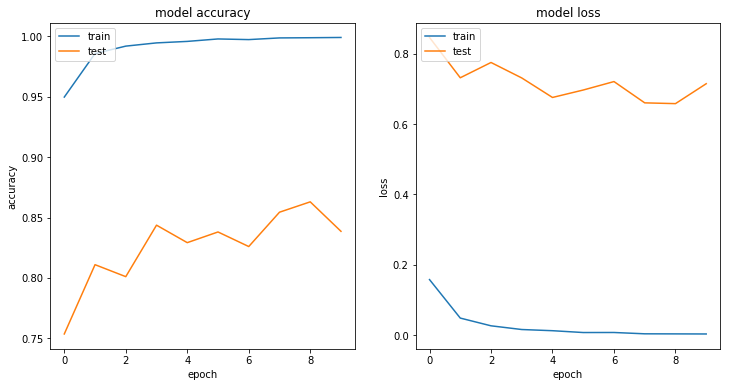

3729/3729 [==============================] - 7s 2ms/step
Score log_loss:  0.7374779664232425

Start KFold number 4 from 5


load drivers: 100%|██████████| 5/5 [00:27<00:00,  5.56s/it]


Split train:  18157 18157
Split valid:  4267 4267
Train drivers:  ['p002', 'p012', 'p014', 'p015', 'p016', 'p021', 'p022', 'p024', 'p026', 'p035', 'p039', 'p042', 'p045', 'p047', 'p050', 'p051', 'p052', 'p061', 'p064', 'p072', 'p075']
Test drivers:  ['p041', 'p049', 'p056', 'p066', 'p081']
Train on 18157 samples, validate on 4267 samples
Epoch 1/1
18157/18157 [==============================] - 50s 3ms/step - loss: 1.3968 - acc: 0.6381 - val_loss: 1.4284 - val_acc: 0.5524
Finish step_1
Train on 18157 samples, validate on 4267 samples
Epoch 1/10
18157/18157 [==============================] - 110s 6ms/step - loss: 0.1670 - acc: 0.9486 - val_loss: 0.5506 - val_acc: 0.8006
Epoch 2/10
18157/18157 [==============================] - 108s 6ms/step - loss: 0.0579 - acc: 0.9834 - val_loss: 0.5028 - val_acc: 0.8329
Epoch 3/10
18157/18157 [==============================] - 108s 6ms/step - loss: 0.0292 - acc: 0.9916 - val_loss: 0.6057 - val_acc: 0.8064
Epoch 4/10
18157/18157 [=======================

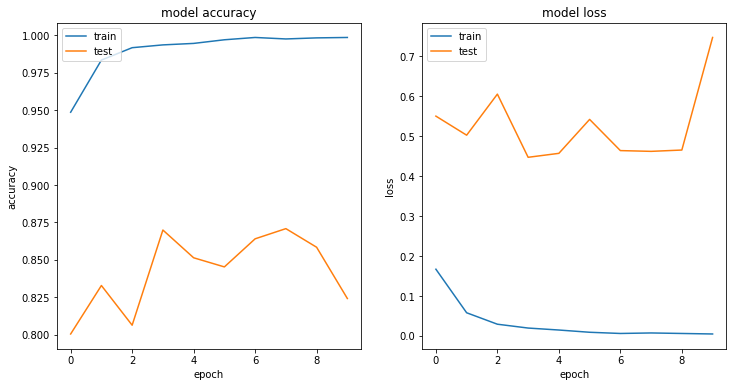

4267/4267 [==============================] - 9s 2ms/step
Score log_loss:  0.749117100530092

Start KFold number 5 from 5


load drivers: 100%|██████████| 5/5 [00:29<00:00,  5.82s/it]


Split train:  17838 17838
Split valid:  4586 4586
Train drivers:  ['p002', 'p012', 'p015', 'p016', 'p021', 'p024', 'p026', 'p039', 'p041', 'p042', 'p045', 'p047', 'p049', 'p050', 'p051', 'p052', 'p056', 'p066', 'p072', 'p075', 'p081']
Test drivers:  ['p014', 'p022', 'p035', 'p061', 'p064']
Train on 17838 samples, validate on 4586 samples
Epoch 1/1
17838/17838 [==============================] - 45s 2ms/step - loss: 1.2868 - acc: 0.6511 - val_loss: 1.3799 - val_acc: 0.5739
Finish step_1
Train on 17838 samples, validate on 4586 samples
Epoch 1/10
17838/17838 [==============================] - 109s 6ms/step - loss: 0.1590 - acc: 0.9501 - val_loss: 0.5201 - val_acc: 0.8133
Epoch 2/10
17838/17838 [==============================] - 108s 6ms/step - loss: 0.0440 - acc: 0.9877 - val_loss: 0.4676 - val_acc: 0.8463
Epoch 3/10
17838/17838 [==============================] - 108s 6ms/step - loss: 0.0264 - acc: 0.9927 - val_loss: 0.3821 - val_acc: 0.8816
Epoch 4/10
17838/17838 [=======================

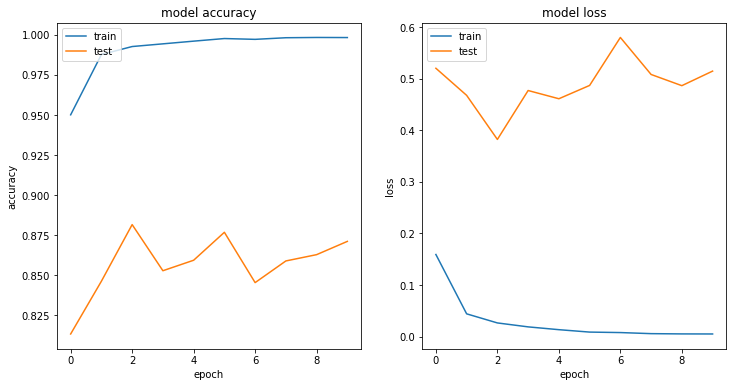

4586/4586 [==============================] - 9s 2ms/step
Score log_loss:  0.5150590578529812

Final log_loss: 0.6876428197363138, nfolds: 5, epoch: 10 


In [19]:
MODEL = vgg16_model
model_str = 'vgg16'
img_rows, img_cols = 224, 224
driver_id = list_subject
first_train_num = 19
nfolds=5
batch_size=32
nb_epoch1=1
nb_epoch2=10    #fine-tune
optimizer2 = SGD(lr=0.0001, momentum=0.9)

run_cross_validation(MODEL, img_rows, img_cols, driver_id, first_train_num, optimizer2,
                     nfolds, batch_size, nb_epoch1, nb_epoch2, random_state_global)

In [22]:
test_predict_and_submit(img_rows, img_cols, model_str, nfolds, nb_epoch2)

read test images...


load test images: 100%|██████████| 79726/79726 [08:25<00:00, 157.69it/s]


79726/79726 [==============================] - 172s 2ms/step
test finished


### ResNet50
输入为(224,224,3)，加载`ResNet50-no_top`模型及预训练权重，`pooling`选择`avg`(GlobalAveragePooling2D)；

直接增加分类层，输出为10类，激活函数为`softmax`。


In [18]:
# ResNet50
def resnet50_model(img_rows, img_cols, color_type=1):
    x = Input(shape=(img_rows, img_cols, 3))
    x = Lambda(imagenet_utils.preprocess_input)(x)
    base_model = ResNet50(input_tensor=x, weights='imagenet',
                          pooling='avg', include_top=False)
    x = base_model.output
    #x = Dense(512, activation='relu', name='fc1')(x)
    #x = Dropout(0.5)(x)
    predictions = Dense(10, activation='softmax', name='predictions')(x)

    resnet_model = Model(inputs=base_model.input, outputs=predictions, name='resnet50')
    return resnet_model


In [27]:
plot_model(resnet50, show_shapes=True, to_file='resnet50_model_simple.png')

Start KFold number 1 from 5


load drivers: 100%|██████████| 6/6 [00:30<00:00,  5.11s/it]


Split train:  17885 17885
Split valid:  4539 4539
Train drivers:  ['p002', 'p012', 'p014', 'p021', 'p022', 'p024', 'p026', 'p035', 'p039', 'p041', 'p045', 'p049', 'p050', 'p051', 'p052', 'p056', 'p061', 'p064', 'p066', 'p081']
Test drivers:  ['p015', 'p016', 'p042', 'p047', 'p072', 'p075']
Train on 17885 samples, validate on 4539 samples
Epoch 1/1
17885/17885 [==============================] - 98s 5ms/step - loss: 0.7233 - acc: 0.8108 - val_loss: 3.9584 - val_acc: 0.2210
Finish step_1
Train on 17885 samples, validate on 4539 samples
Epoch 1/10
17885/17885 [==============================] - 102s 6ms/step - loss: 0.1333 - acc: 0.9787 - val_loss: 1.2121 - val_acc: 0.6162
Epoch 2/10
17885/17885 [==============================] - 97s 5ms/step - loss: 0.0511 - acc: 0.9942 - val_loss: 1.2025 - val_acc: 0.6272
Epoch 3/10
17885/17885 [==============================] - 97s 5ms/step - loss: 0.0308 - acc: 0.9980 - val_loss: 1.1579 - val_acc: 0.6369
Epoch 4/10
17885/17885 [=========================

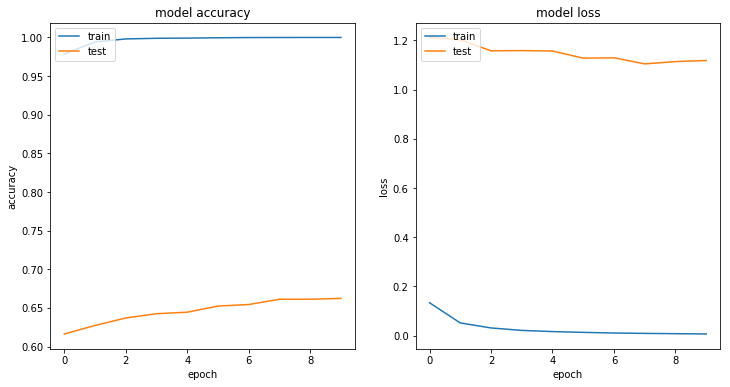

4539/4539 [==============================] - 11s 2ms/step
Score log_loss:  1.1184787377183385

Start KFold number 2 from 5


load drivers: 100%|██████████| 5/5 [00:33<00:00,  6.74s/it]


Split train:  17121 17121
Split valid:  5303 5303
Train drivers:  ['p002', 'p012', 'p014', 'p015', 'p016', 'p022', 'p035', 'p039', 'p041', 'p042', 'p047', 'p049', 'p050', 'p052', 'p056', 'p061', 'p064', 'p066', 'p072', 'p075', 'p081']
Test drivers:  ['p021', 'p024', 'p026', 'p045', 'p051']
Train on 17121 samples, validate on 5303 samples
Epoch 1/1
17121/17121 [==============================] - 46s 3ms/step - loss: 0.7893 - acc: 0.7932 - val_loss: 10.2109 - val_acc: 0.1033
Finish step_1
Train on 17121 samples, validate on 5303 samples
Epoch 1/10
17121/17121 [==============================] - 95s 6ms/step - loss: 0.1596 - acc: 0.9714 - val_loss: 0.7307 - val_acc: 0.7537
Epoch 2/10
17121/17121 [==============================] - 89s 5ms/step - loss: 0.0572 - acc: 0.9938 - val_loss: 0.6637 - val_acc: 0.7728
Epoch 3/10
17121/17121 [==============================] - 89s 5ms/step - loss: 0.0348 - acc: 0.9972 - val_loss: 0.6312 - val_acc: 0.7813
Epoch 4/10
17121/17121 [=========================

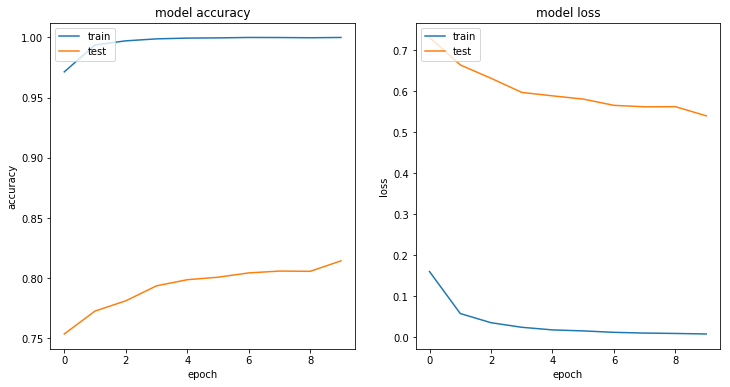

5303/5303 [==============================] - 11s 2ms/step
Score log_loss:  0.5395621902838247

Start KFold number 3 from 5


load drivers: 100%|██████████| 5/5 [00:23<00:00,  4.78s/it]


Split train:  18695 18695
Split valid:  3729 3729
Train drivers:  ['p014', 'p015', 'p016', 'p021', 'p022', 'p024', 'p026', 'p035', 'p041', 'p042', 'p045', 'p047', 'p049', 'p051', 'p056', 'p061', 'p064', 'p066', 'p072', 'p075', 'p081']
Test drivers:  ['p002', 'p012', 'p039', 'p050', 'p052']
Train on 18695 samples, validate on 3729 samples
Epoch 1/1
18695/18695 [==============================] - 43s 2ms/step - loss: 0.7158 - acc: 0.8122 - val_loss: 6.0978 - val_acc: 0.1773
Finish step_1
Train on 18695 samples, validate on 3729 samples
Epoch 1/10
18695/18695 [==============================] - 107s 6ms/step - loss: 0.1313 - acc: 0.9776 - val_loss: 1.0201 - val_acc: 0.6640
Epoch 2/10
18695/18695 [==============================] - 100s 5ms/step - loss: 0.0485 - acc: 0.9948 - val_loss: 0.9521 - val_acc: 0.6852
Epoch 3/10
18695/18695 [==============================] - 100s 5ms/step - loss: 0.0291 - acc: 0.9976 - val_loss: 0.9204 - val_acc: 0.6983
Epoch 4/10
18695/18695 [=======================

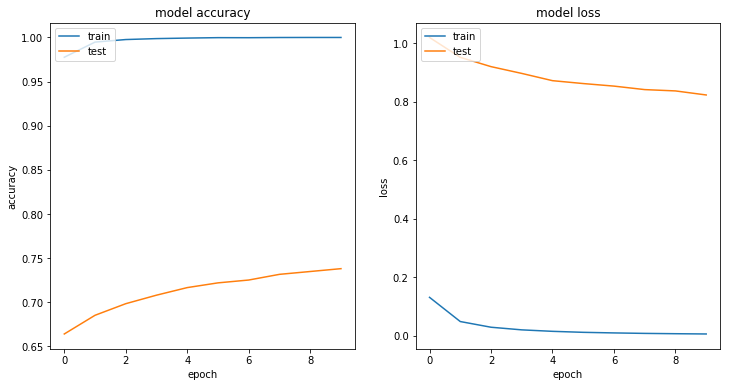

3729/3729 [==============================] - 10s 3ms/step
Score log_loss:  0.8234534130740917

Start KFold number 4 from 5


load drivers: 100%|██████████| 5/5 [00:26<00:00,  5.39s/it]


Split train:  18157 18157
Split valid:  4267 4267
Train drivers:  ['p002', 'p012', 'p014', 'p015', 'p016', 'p021', 'p022', 'p024', 'p026', 'p035', 'p039', 'p042', 'p045', 'p047', 'p050', 'p051', 'p052', 'p061', 'p064', 'p072', 'p075']
Test drivers:  ['p041', 'p049', 'p056', 'p066', 'p081']
Train on 18157 samples, validate on 4267 samples
Epoch 1/1
18157/18157 [==============================] - 44s 2ms/step - loss: 0.7588 - acc: 0.7989 - val_loss: 6.4860 - val_acc: 0.1462
Finish step_1
Train on 18157 samples, validate on 4267 samples
Epoch 1/10
18157/18157 [==============================] - 109s 6ms/step - loss: 0.1404 - acc: 0.9778 - val_loss: 0.7715 - val_acc: 0.7406
Epoch 2/10
18157/18157 [==============================] - 100s 6ms/step - loss: 0.0536 - acc: 0.9947 - val_loss: 0.7080 - val_acc: 0.7593
Epoch 3/10
18157/18157 [==============================] - 100s 6ms/step - loss: 0.0320 - acc: 0.9974 - val_loss: 0.6765 - val_acc: 0.7724
Epoch 4/10
18157/18157 [=======================

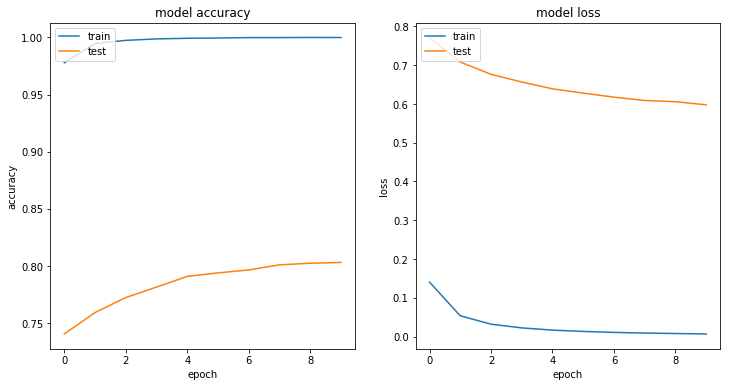

4267/4267 [==============================] - 12s 3ms/step
Score log_loss:  0.5976998273664258

Start KFold number 5 from 5


load drivers: 100%|██████████| 5/5 [00:28<00:00,  5.78s/it]


Split train:  17838 17838
Split valid:  4586 4586
Train drivers:  ['p002', 'p012', 'p015', 'p016', 'p021', 'p024', 'p026', 'p039', 'p041', 'p042', 'p045', 'p047', 'p049', 'p050', 'p051', 'p052', 'p056', 'p066', 'p072', 'p075', 'p081']
Test drivers:  ['p014', 'p022', 'p035', 'p061', 'p064']
Train on 17838 samples, validate on 4586 samples
Epoch 1/1
17838/17838 [==============================] - 46s 3ms/step - loss: 0.7508 - acc: 0.8031 - val_loss: 4.6410 - val_acc: 0.2375
Finish step_1
Train on 17838 samples, validate on 4586 samples
Epoch 1/10
17838/17838 [==============================] - 102s 6ms/step - loss: 0.1377 - acc: 0.9792 - val_loss: 0.7717 - val_acc: 0.7218
Epoch 2/10
17838/17838 [==============================] - 92s 5ms/step - loss: 0.0531 - acc: 0.9947 - val_loss: 0.7068 - val_acc: 0.7497
Epoch 3/10
17838/17838 [==============================] - 92s 5ms/step - loss: 0.0326 - acc: 0.9978 - val_loss: 0.6725 - val_acc: 0.7645
Epoch 4/10
17838/17838 [=========================

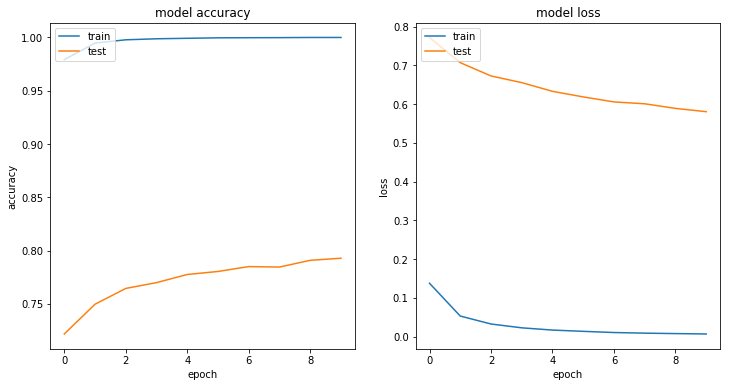

4586/4586 [==============================] - 12s 3ms/step
Score log_loss:  0.5803213359230891

Final log_loss: 0.7233530981469753, nfolds: 5, epoch: 10 


In [19]:
MODEL = resnet50_model
model_str = 'resnet50'
img_rows, img_cols = 224, 224
driver_id = list_subject
first_train_num = 175
nfolds=5
batch_size=32
nb_epoch1=1
nb_epoch2=20
optimizer2 = SGD(lr=0.0001, momentum=0.9)

run_cross_validation(MODEL, img_rows, img_cols, driver_id, first_train_num, optimizer2,
                     nfolds, batch_size, nb_epoch1, nb_epoch2, random_state_global)

In [20]:
# ResNet50 预测
test_predict_and_submit(img_rows, img_cols, model_str, nfolds, nb_epoch2)

read test images...


load test images: 100%|██████████| 79726/79726 [22:38<00:00, 58.70it/s]  


79726/79726 [==============================] - 200s 3ms/step
test finished


### InceptionResNetV2
输入为（299，299，3），加载`InceptionResNetV2-no_top`模型及预训练权重，`pooling`选择`avg`(GlobalAveragePooling2D)；

直接增加分类层，输出为10类，激活函数为`softmax`。


In [21]:
# InceptionResNetV2
def inception_resnet_v2_model(img_rows, img_cols, color_type=1):
    x = Input(shape=(img_rows, img_cols, 3))
    x = Lambda(inception_resnet_v2.preprocess_input)(x)
    base_model = InceptionResNetV2(input_tensor=x, weights='imagenet',
                                   pooling='avg', include_top=False)
    x = base_model.output
    predictions = Dense(10, activation='softmax', name='predictions')(x)

    inception_model = Model(inputs=base_model.input, outputs=predictions, name='inception_resnet_v2')
    return inception_model


In [24]:
#plot_model(inception_resnet, show_shapes=True, to_file='inception_resnet_v2_model_simple.png')

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.517034 to fit



Start KFold number 1 from 5


load drivers: 100%|██████████| 6/6 [00:32<00:00,  5.39s/it]


Split train:  17885 17885
Split valid:  4539 4539
Train drivers:  ['p002', 'p012', 'p014', 'p021', 'p022', 'p024', 'p026', 'p035', 'p039', 'p041', 'p045', 'p049', 'p050', 'p051', 'p052', 'p056', 'p061', 'p064', 'p066', 'p081']
Test drivers:  ['p015', 'p016', 'p042', 'p047', 'p072', 'p075']
Train on 17885 samples, validate on 4539 samples
Epoch 1/1
17885/17885 [==============================] - 124s 7ms/step - loss: 1.6205 - acc: 0.5028 - val_loss: 4.0762 - val_acc: 0.1379
Finish step_1
Train on 17885 samples, validate on 4539 samples
Epoch 1/10
17885/17885 [==============================] - 317s 18ms/step - loss: 0.1240 - acc: 0.9633 - val_loss: 1.2980 - val_acc: 0.6700
Epoch 2/10
17885/17885 [==============================] - 289s 16ms/step - loss: 0.0135 - acc: 0.9964 - val_loss: 0.7018 - val_acc: 0.8079
Epoch 3/10
17885/17885 [==============================] - 289s 16ms/step - loss: 0.0021 - acc: 0.9994 - val_loss: 0.4097 - val_acc: 0.8735
Epoch 4/10
17885/17885 [===================

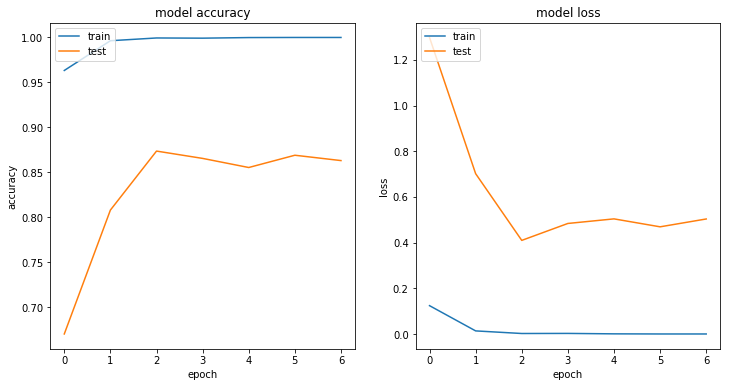

4539/4539 [==============================] - 25s 6ms/step
Score log_loss:  0.5046832565655879

Start KFold number 2 from 5


load drivers: 100%|██████████| 5/5 [00:35<00:00,  7.14s/it]


Split train:  17121 17121
Split valid:  5303 5303
Train drivers:  ['p002', 'p012', 'p014', 'p015', 'p016', 'p022', 'p035', 'p039', 'p041', 'p042', 'p047', 'p049', 'p050', 'p052', 'p056', 'p061', 'p064', 'p066', 'p072', 'p075', 'p081']
Test drivers:  ['p021', 'p024', 'p026', 'p045', 'p051']
Train on 17121 samples, validate on 5303 samples
Epoch 1/1
17121/17121 [==============================] - 131s 8ms/step - loss: 1.7236 - acc: 0.4561 - val_loss: 2.9331 - val_acc: 0.1460
Finish step_1
Train on 17121 samples, validate on 5303 samples
Epoch 1/10
17121/17121 [==============================] - 332s 19ms/step - loss: 0.1545 - acc: 0.9540 - val_loss: 0.8612 - val_acc: 0.7918
Epoch 2/10
17121/17121 [==============================] - 301s 18ms/step - loss: 0.0107 - acc: 0.9972 - val_loss: 1.0008 - val_acc: 0.8505
Epoch 3/10
17121/17121 [==============================] - 301s 18ms/step - loss: 0.0060 - acc: 0.9986 - val_loss: 0.8983 - val_acc: 0.7715
Epoch 4/10
17121/17121 [===================

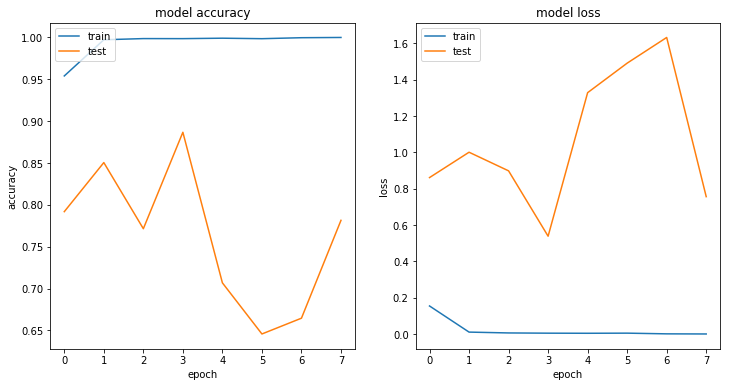

5303/5303 [==============================] - 35s 7ms/step
Score log_loss:  0.7576812031510692

Start KFold number 3 from 5


load drivers: 100%|██████████| 5/5 [00:25<00:00,  5.01s/it]


Split train:  18695 18695
Split valid:  3729 3729
Train drivers:  ['p014', 'p015', 'p016', 'p021', 'p022', 'p024', 'p026', 'p035', 'p041', 'p042', 'p045', 'p047', 'p049', 'p051', 'p056', 'p061', 'p064', 'p066', 'p072', 'p075', 'p081']
Test drivers:  ['p002', 'p012', 'p039', 'p050', 'p052']
Train on 18695 samples, validate on 3729 samples
Epoch 1/1
18695/18695 [==============================] - 121s 6ms/step - loss: 1.6267 - acc: 0.4905 - val_loss: 3.6757 - val_acc: 0.1429
Finish step_1
Train on 18695 samples, validate on 3729 samples
Epoch 1/10
18695/18695 [==============================] - 341s 18ms/step - loss: 0.1149 - acc: 0.9669 - val_loss: 0.5703 - val_acc: 0.8632
Epoch 2/10
18695/18695 [==============================] - 300s 16ms/step - loss: 0.0057 - acc: 0.9988 - val_loss: 0.5657 - val_acc: 0.8673
Epoch 3/10
18695/18695 [==============================] - 299s 16ms/step - loss: 0.0018 - acc: 0.9997 - val_loss: 0.5306 - val_acc: 0.8919
Epoch 4/10
18695/18695 [===================

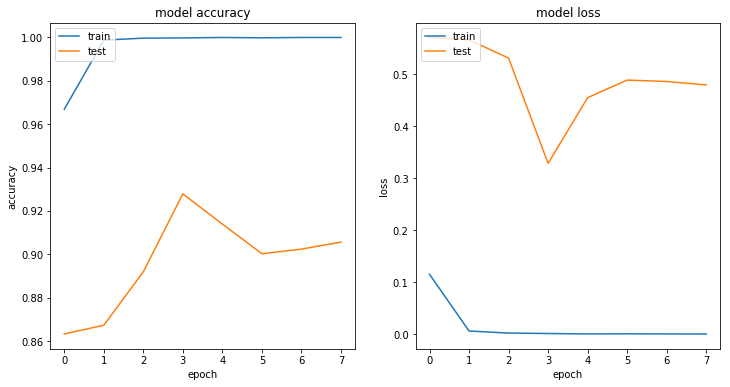

3729/3729 [==============================] - 27s 7ms/step
Score log_loss:  0.4822405276363298

Start KFold number 4 from 5


load drivers: 100%|██████████| 5/5 [00:28<00:00,  5.63s/it]


Split train:  18157 18157
Split valid:  4267 4267
Train drivers:  ['p002', 'p012', 'p014', 'p015', 'p016', 'p021', 'p022', 'p024', 'p026', 'p035', 'p039', 'p042', 'p045', 'p047', 'p050', 'p051', 'p052', 'p061', 'p064', 'p072', 'p075']
Test drivers:  ['p041', 'p049', 'p056', 'p066', 'p081']
Train on 18157 samples, validate on 4267 samples
Epoch 1/1
18157/18157 [==============================] - 128s 7ms/step - loss: 1.6511 - acc: 0.4865 - val_loss: 4.8198 - val_acc: 0.1008
Finish step_1
Train on 18157 samples, validate on 4267 samples
Epoch 1/10
18157/18157 [==============================] - 340s 19ms/step - loss: 0.1404 - acc: 0.9594 - val_loss: 0.2967 - val_acc: 0.9034
Epoch 2/10
18157/18157 [==============================] - 294s 16ms/step - loss: 0.0122 - acc: 0.9968 - val_loss: 0.3843 - val_acc: 0.8915
Epoch 3/10
18157/18157 [==============================] - 294s 16ms/step - loss: 0.0028 - acc: 0.9992 - val_loss: 0.3456 - val_acc: 0.9201
Epoch 4/10
18157/18157 [===================

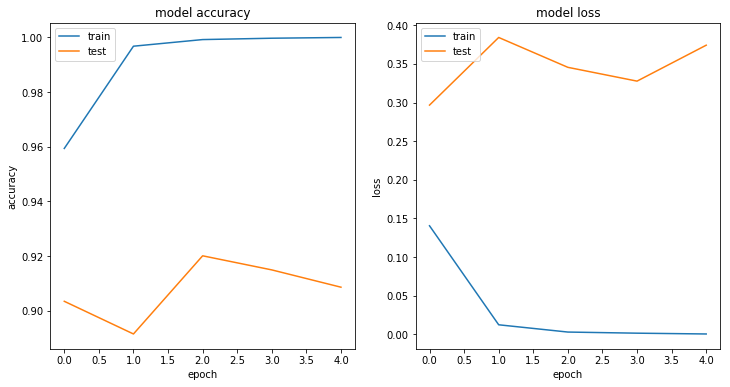

4267/4267 [==============================] - 34s 8ms/step
Score log_loss:  0.37502766487105277

Start KFold number 5 from 5


load drivers: 100%|██████████| 5/5 [00:29<00:00,  6.00s/it]


Split train:  17838 17838
Split valid:  4586 4586
Train drivers:  ['p002', 'p012', 'p015', 'p016', 'p021', 'p024', 'p026', 'p039', 'p041', 'p042', 'p045', 'p047', 'p049', 'p050', 'p051', 'p052', 'p056', 'p066', 'p072', 'p075', 'p081']
Test drivers:  ['p014', 'p022', 'p035', 'p061', 'p064']
Train on 17838 samples, validate on 4586 samples
Epoch 1/1
17838/17838 [==============================] - 139s 8ms/step - loss: 1.5946 - acc: 0.5039 - val_loss: 4.7405 - val_acc: 0.1171
Finish step_1
Train on 17838 samples, validate on 4586 samples
Epoch 1/10
17838/17838 [==============================] - 347s 19ms/step - loss: 0.1314 - acc: 0.9623 - val_loss: 0.3617 - val_acc: 0.8816
Epoch 2/10
17838/17838 [==============================] - 291s 16ms/step - loss: 0.0100 - acc: 0.9971 - val_loss: 0.3143 - val_acc: 0.9189
Epoch 3/10
17838/17838 [==============================] - 291s 16ms/step - loss: 0.0020 - acc: 0.9994 - val_loss: 0.3410 - val_acc: 0.8964
Epoch 4/10
17838/17838 [===================

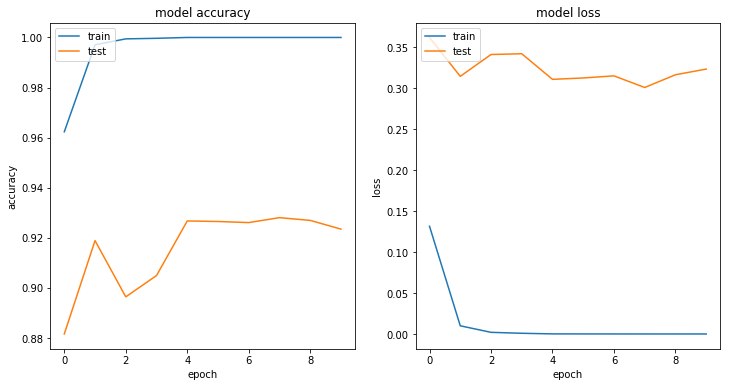

4586/4586 [==============================] - 40s 9ms/step
Score log_loss:  0.3253184732749202

Final log_loss: 0.4994278101079541, nfolds: 5, epoch: 10 


In [23]:
MODEL = inception_resnet_v2_model
model_str = 'inception_resnet_v2'
img_rows, img_cols = 299, 299
driver_id = list_subject
first_train_num = 781
nfolds=5
batch_size=32
nb_epoch1=1
nb_epoch2=10
optimizer2 = 'adadelta'

history_inception = run_cross_validation(MODEL, img_rows, img_cols, driver_id, first_train_num, optimizer2,
                                         nfolds, batch_size, nb_epoch1, nb_epoch2, random_state_global)

In [18]:
model_str = 'inception_resnet_v2'
img_rows, img_cols = 299, 299
nfolds=5
nb_epoch2=10
# InceptionResNet V2 预测
test_predict_and_submit(img_rows, img_cols, model_str, nfolds, nb_epoch2)

read test images...


load test images: 100%|██████████| 79726/79726 [26:55<00:00, 49.36it/s]  


79726/79726 [==============================] - 481s 6ms/step
test finished
